# Vietoris-Rips Filtration Visualization

- Input: path to directory containing embeddings saved as pickle files
- Output: Visualization of filtraton progressing on a downsampled embedding with betti number/homology group counts at each filtration frame shown. Also can print correspondinng persistence diagram


** note this code is intended for visualizing TDA and how the filtration works, not for generating ~real~ TDA data. The embeddings are dramatically downsampled so the plots are readable.

Author: @emilyekstrum
<br> 11/17/25

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
import matplotlib.patches as mpatches
import pickle
import os
from pathlib import Path
from persim import plot_diagrams
import pickle as pkl
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [ ]:
# utils

def edge_color_from_betti(b0, b1, b2):
    """Assign edge color  on plot based on homology presence priority (β₂>β₁>β₀).
    Args:
        b0, b1, b2: Betti numbers (ints)
    Returns:
        color string for matplotlib"""
    
    if b2 > 0:
        return "tab:green"
    if b1 > 0:
        return "tab:orange"
    if b0 > 0:
        return "tab:blue"
    return "0.5"  # gray


def _betti_at_t(intervals, t):
    """Compute Betti(t): number of features alive at filtration value t.
    Args:
        intervals: np.ndarray of shape (n_features, 2) with birth/death pairs
        t: filtration value (float)
    Returns:
        Betti number at t (int)"""
    
    if intervals is None or len(intervals) == 0:
        return 0
    births = intervals[:, 0]
    deaths = intervals[:, 1]
    alive = (births <= t) & ((deaths > t) | np.isinf(deaths))
    return int(np.count_nonzero(alive))


def load_embeddings_from_directory(directory_path):
    """
    Load all pickle files from a directory and create an embedding_dict.
    Assumes each pickle file contains a dictionary with an 'embedding' key.
    
    Args:
        directory_path : str path to directory containing pickle files
        
    Returns:
        embedding_dict : dict dictionary mapping filenames (without .pkl extension) to their data
    """
    directory_path = Path(directory_path)
    if not directory_path.exists():
        raise ValueError(f"Directory does not exist: {directory_path}")
    
    embedding_dict = {}
    pickle_files = list(directory_path.glob("*.pkl")) + list(directory_path.glob("*.pickle"))
    
    if len(pickle_files) == 0:
        raise ValueError(f"No pickle files found in directory: {directory_path}")
    
    print(f"Found {len(pickle_files)} pickle file(s) in {directory_path}")
    
    # Some fantastic chat code to handle various pickle loading issues
    # If you are confused then so am I, so just ask chat :)
    for pkl_file in pickle_files:
        try:
            # Try loading with standard pickle first
            try:
                with open(pkl_file, "rb") as f:
                    loaded_data = pickle.load(f)
            except (RuntimeError, ValueError) as e:
                # If it's a CUDA/torch error, try with torch.load
                if "CUDA" in str(e) or "torch" in str(e).lower():
                    try:
                        import torch
                        loaded_data = torch.load(pkl_file, map_location=torch.device('cpu'))
                    except Exception as e2:
                        print(f"Error loading {pkl_file.name} with torch.load: {e2}")
                        continue
                else:
                    raise
            
            file_stem = pkl_file.stem  # Get filename without extension
            
            # Handle different data structures
            # Case 1: Tuple format (single_session_dict, session_names) as in visualize_filtration.ipynb
            if isinstance(loaded_data, tuple) and len(loaded_data) >= 2:
                single_session_dict = loaded_data[0]
                # session_names is the second element, but we can get it from dict keys
                
                if isinstance(single_session_dict, dict):
                    session_names = list(single_session_dict.keys())
                    
                    # Process each name in the session
                    for session_name in session_names:
                        try:
                            # Access: single_session_dict[name]['embedding']
                            if isinstance(single_session_dict[session_name], dict) and 'embedding' in single_session_dict[session_name]:
                                embedding = single_session_dict[session_name]['embedding']
                                
                                # Convert PyTorch tensor to numpy if needed
                                if hasattr(embedding, 'cpu'):
                                    embedding = embedding.cpu().numpy()
                                elif hasattr(embedding, 'numpy'):
                                    embedding = embedding.numpy()
                                else:
                                    embedding = np.array(embedding)
                                
                                # Create unique key: filename_sessionname
                                unique_name = f"{file_stem}_{session_name}" if len(session_names) > 1 else file_stem
                                
                                # Store in embedding_dict
                                embedding_dict[unique_name] = {
                                    'embedding': embedding,
                                    'original_session': session_name,
                                    'filename': pkl_file.name
                                }
                                
                                print(f"  Loaded: {unique_name} (from session '{session_name}')")
                            else:
                                print(f"  Warning: {pkl_file.name}[{session_name}] doesn't have expected 'embedding' key")
                        except Exception as e:
                            print(f"  Warning: Error processing {session_name} in {pkl_file.name}: {e}")
                            continue
            
            # Case 2: Direct dictionary format (session[name]['embedding'])
            elif isinstance(loaded_data, dict):
                session_names = list(loaded_data.keys())
                
                # Process each name in the session
                for session_name in session_names:
                    try:
                        # Access: session[name]['embedding']
                        if isinstance(loaded_data[session_name], dict) and 'embedding' in loaded_data[session_name]:
                            embedding = loaded_data[session_name]['embedding']
                            
                            # Convert PyTorch tensor to numpy if needed
                            if hasattr(embedding, 'cpu'):
                                embedding = embedding.cpu().numpy()
                            elif hasattr(embedding, 'numpy'):
                                embedding = embedding.numpy()
                            else:
                                embedding = np.array(embedding)
                            
                            # Create unique key: filename_sessionname
                            unique_name = f"{file_stem}_{session_name}" if len(session_names) > 1 else file_stem
                            
                            # Store in embedding_dict
                            embedding_dict[unique_name] = {
                                'embedding': embedding,
                                'original_session': session_name,
                                'filename': pkl_file.name
                            }
                            
                            #print(f"  Loaded: {unique_name} (from session '{session_name}')")
                        else:
                            print(f"  Warning: {pkl_file.name}[{session_name}] doesn't have expected 'embedding' key")
                    except Exception as e:
                        print(f"  Warning: Error processing {session_name} in {pkl_file.name}: {e}")
                        continue
            else:
                print(f"  Warning: {pkl_file.name} has unexpected format. Type: {type(loaded_data)}")
                continue
                
        except Exception as e:
            print(f"Error loading {pkl_file.name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    return embedding_dict


def downsample_embedding(embedding, n_samples=None, sampling_method='random'):
    """Downsample points for faster and clearer visualization.
    Args:
        embedding : np.ndarray of shape (n_points, n_dims)
        n_samples : int or None number of points to sample (default: min(500, max(50, 10% of n_points)))
        sampling_method : str 'random', 'uniform', or 'first' method of sampling points
    Returns:
        downsampled_embedding : np.ndarray of shape (n_samples, n_dims)
        selected_indices : list of int indices of selected points in original embedding """
    
    n_points = len(embedding)
    if n_samples is None:
        n_samples = min(500, max(50, int(0.1 * n_points)))
    if n_samples >= n_points:
        return embedding, list(range(n_points))

    if sampling_method == 'random':
        indices = np.random.choice(n_points, size=n_samples, replace=False)
    elif sampling_method == 'uniform':
        indices = np.linspace(0, n_points - 1, n_samples, dtype=int)
    elif sampling_method == 'first':
        indices = np.arange(n_samples)
    else:
        raise ValueError("sampling_method must be 'random', 'uniform', or 'first'")

    indices = np.sort(indices)
    return embedding[indices], indices.tolist()


def increase_ball_epsilon(embedding, diameter):
    """
    Create Euclidean balls of radius = diameter/2 and connect overlapping pairs.
    Compute β₀, β₁, β₂ at this filtration diameter using Ripser.
    Args:
        embedding : np.ndarray of shape (n_points, n_dims)
        diameter : float filtration diameter
    Returns:
        result : dict with keys:
            'balls' : dict mapping point index to ball info (center, radius, center_idxx)
            'connections' : list of tuples (i, j) for connected ball pairs
            'edge_distances' : dict mapping (i, j) to distance between centers
            'epsilon' : float ball radius
            'diameter' : float filtration diameter
            'num_connections' : int number of connections
            'betti0' : int Betti number β₀ at this diameter
            'betti1' : int Betti number β₁ at this diameter
            'betti2' : int Betti number β₂ at this diameter
            'dgms' : list of np.ndarray persistence diagrams from Ripser"""
    
    epsilon = diameter / 2.0
    n_points = len(embedding)

    balls = {i: {'center': embedding[i], 'radius': epsilon, 'center_idx': i}
             for i in range(n_points)}

    # Pairwise overlaps with distances stored
    connections = []
    edge_distances = {}  # Store distance for each edge
    for i in range(n_points):
        pi = embedding[i]
        for j in range(i + 1, n_points):
            pj = embedding[j]
            dist = np.linalg.norm(pi - pj)
            if dist <= diameter:
                connections.append((i, j))
                edge_distances[(i, j)] = dist

    dgms = ripser(embedding, maxdim=2, thresh=diameter)["dgms"]
    betti0 = _betti_at_t(dgms[0], diameter) if len(dgms) > 0 else 0
    betti1 = _betti_at_t(dgms[1], diameter) if len(dgms) > 1 else 0
    betti2 = _betti_at_t(dgms[2], diameter) if len(dgms) > 2 else 0

    return {
        'balls': balls,
        'connections': connections,
        'edge_distances': edge_distances,
        'epsilon': epsilon,
        'diameter': diameter,
        'num_connections': len(connections),
        'betti0': betti0,
        'betti1': betti1,
        'betti2': betti2,
        'dgms': dgms
    }


def create_3d_sphere(ax, center, radius, color='lightblue', alpha=0.02):
    """Plot a 3D sphere at given center.
    Args:
        ax : matplotlib 3D axis
        center : list or np.ndarray of shape (3,) sphere center coordinates
        radius : float sphere radius
        color : str sphere color
        alpha : float sphere transparency"""

    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color=color, alpha=0.005,
                    linewidth=0.3, edgecolor='blue', zorder=1)


def demonstrate_filtration_progression(embedding, diameter_range, n_steps=5, show_spheres=True):
    """
    Visualize the Vietoris–Rips filtration in 3D.
    Edge colors indicate which homology group exists at each diameter.
    Only edges that are part of newly born cycles are colored.

    Args:
        embedding : np.ndarray of shape (n_points, n_dims)
        diameter_range : tuple (min_diameter, max_diameter)
        n_steps : int number of filtration steps to visualize
        show_spheres : bool whether to plot spheres around points"""
    
    min_d, max_d = diameter_range
    diameters = np.linspace(min_d, max_d, n_steps)
    tolerance = (max_d - min_d) / (n_steps * 10)  # Small tolerance for edge birth detection

    if embedding.shape[1] == 2:
        embedding_3d = np.column_stack([embedding, np.zeros(len(embedding))])
        print("Note: Converting 2D embedding to 3D for visualization (z=0)")
    elif embedding.shape[1] >= 3:
        embedding_3d = embedding[:, :3]
        if embedding.shape[1] > 3:
            print(f"Note: Using first 3 dimensions from {embedding.shape[1]}D embedding")
    else:
        raise ValueError("Embedding must have at least 2 dimensions")

    rows = 2
    cols = int(np.ceil(n_steps / rows))
    fig = plt.figure(figsize=(5 * cols, 10))

    # Track previous state
    prev_betti0, prev_betti1, prev_betti2 = 0, 0, 0
    prev_connections = set()
    
    # Store all colored edges across the filtration
    all_colored_edges = {}  # (i, j) -> color

    for i, d in enumerate(diameters):
        res = increase_ball_epsilon(embedding_3d, d)
        ax = fig.add_subplot(rows, cols, i + 1, projection='3d')

        # Scatter points
        centers = np.array([b['center'] for b in res['balls'].values()])
        ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
                   cmap = 'hsv', c=np.linspace(0,1,len(embedding)), clim=(0,1), rasterized=True, 
                   s=7, alpha=0.9, edgecolor="black", linewidth=0.4)

        # Optional spheres
        if show_spheres:
            for b in res['balls'].values():
                create_3d_sphere(ax, b['center'], b['radius'])

        # Detect new homology groups
        new_betti0 = res['betti0'] > prev_betti0
        new_betti1 = res['betti1'] > prev_betti1
        new_betti2 = res['betti2'] > prev_betti2

        # Current connections set
        current_connections = set(res['connections'])
        new_edges = current_connections - prev_connections

        # Identify edges that are part of newly born cycles
        edges_in_new_cycle = []
        
        if new_betti2 and len(res['dgms']) > 2 and len(res['dgms'][2]) > 0:
            # Find b2 intervals born at this diameter (within tolerance)
            beta2_intervals = res['dgms'][2]
            births = beta2_intervals[:, 0]
            births_at_d = beta2_intervals[np.abs(births - d) <= tolerance]
            if len(births_at_d) > 0:
                # Color new edges that appear at or near the birth diameter
                for edge in new_edges:
                    edge_dist = res['edge_distances'][edge]
                    if abs(edge_dist - d) <= tolerance:
                        edges_in_new_cycle.append(("green", edge))
        
        elif new_betti1 and len(res['dgms']) > 1 and len(res['dgms'][1]) > 0:
            # Find b1 intervals born at this diameter (within tolerance)
            beta1_intervals = res['dgms'][1]
            births = beta1_intervals[:, 0]
            births_at_d = beta1_intervals[np.abs(births - d) <= tolerance]
            if len(births_at_d) > 0:
                # Color new edges that appear at or near the birth diameter
                for edge in new_edges:
                    edge_dist = res['edge_distances'][edge]
                    if abs(edge_dist - d) <= tolerance:
                        edges_in_new_cycle.append(("orange", edge))
        
        elif new_betti0 and len(res['dgms']) > 0 and len(res['dgms'][0]) > 0:
            # Find b0 intervals born at this diameter (within tolerance)
            beta0_intervals = res['dgms'][0]
            births = beta0_intervals[:, 0]
            births_at_d = beta0_intervals[np.abs(births - d) <= tolerance]
            if len(births_at_d) > 0:
                # Color new edges that appear at or near the birth diameter
                for edge in new_edges:
                    edge_dist = res['edge_distances'][edge]
                    if abs(edge_dist - d) <= tolerance:
                        edges_in_new_cycle.append(("blue", edge))

        # Color edges that are part of newly born cycles
        for color_name, edge in edges_in_new_cycle:
            color_map = {"blue": "tab:blue", "orange": "tab:orange", "green": "tab:green"}
            #all_colored_edges[edge] = color_map[color_name]

        # Plot all connections 
        for (j, k) in res['connections']:
            p1 = res['balls'][j]['center']
            p2 = res['balls'][k]['center']
            # Use stored color if edge was part of a new cycle, otherwise gray
            edge_color = all_colored_edges.get((j, k), "0.5")
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]],
                    alpha=0.9, linewidth=0.8, c=edge_color, zorder=2)

        # Update
        prev_betti0, prev_betti1, prev_betti2 = res['betti0'], res['betti1'], res['betti2']
        prev_connections = current_connections

        ax.set_title(f"ε={d:.2f}\nH₀={res['betti0']}  H₁={res['betti1']}  H₂={res['betti2']}",
                     fontsize=16, pad=6, y=0.94)
        ax.set_box_aspect([1, 1, 1])
        ax.view_init(elev=15, azim=45)
        ax.set_axis_off()

    # add in colors for new topological features formed - I think this is broken but I am not sure
    legend_patches = [
        #mpatches.Patch(color="tab:blue",   label=r"new β₀"),
       # mpatches.Patch(color="tab:orange", label=r"new β₁"),
       # mpatches.Patch(color="tab:green",  label=r"new β₂"),
       # mpatches.Patch(color="0.5",        label="other edges"),
    ]
    fig.legend(handles=legend_patches, loc="lower center", ncol=4, frameon=False, fontsize=16, title_fontsize=18)

    cax = fig.add_axes([0.02, 0.6, 0.01, 0.17])  # [left, bottom, width, height]
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='hsv'), cax=cax)
    cbar.ax.set_title("Normalized Time\nAcross Trials", fontsize=16, pad=10)

    plt.suptitle('Filtration Progression',
                 fontsize=30, fontweight='bold')
    plt.tight_layout()
    plt.show()


def embedding_filtration_workflow(embedding_dict, mouse_name,
                                       n_samples=200, diameter_range=(0.05, 0.3),
                                       n_filtration_steps=5, sampling_method='random'):
    """
    Main workflow to visualize the Vietoris–Rips filtration.
    Can adjust for edges to recolor based on which homology group appears - still a work in progress

    Args:
        embedding_dict : dict dictionary mapping mouse/session names to their data
        mouse_name : str key in embedding_dict to select embedding
        n_samples : int number of points to downsample for visualization
        diameter_range : tuple (min_diameter, max_diameter) for filtration
        n_filtration_steps : int number of filtration steps to visualize
        sampling_method : str 'random', 'uniform', or 'first' method of sampling points
    Returns:
        result : dict with keys:
            'original_embedding' : np.ndarray original full embedding
            'downsampled_embedding' : np.ndarray downsampled embedding
            'selected_indices' : list of int indices of selected points in original embedding"""

    if mouse_name not in embedding_dict:
        raise ValueError(f"Mouse '{mouse_name}' not found. Available: {list(embedding_dict.keys())}")

    original_embedding = embedding_dict[mouse_name]["embedding"]
    print(f"Original embedding shape: {original_embedding.shape}")

    downsampled_embedding, selected_indices = downsample_embedding(
        original_embedding, n_samples=n_samples, sampling_method=sampling_method
    )
    print(f"Downsampled to {len(downsampled_embedding)} points.")

    ds_ripser = ripser(downsampled_embedding, maxdim=2)
    downsampled_dgms = ds_ripser["dgms"]

    demonstrate_filtration_progression(downsampled_embedding, diameter_range, n_steps=n_filtration_steps)

    return {
        'original_embedding': original_embedding,
        'downsampled_embedding': downsampled_embedding,
        'selected_indices': selected_indices
    }



Loading embeddings from: C:\Users\denmanlab\Desktop\Emily_rotation\CEBRA\3d\raw\
Found 8 pickle file(s) in C:\Users\denmanlab\Desktop\Emily_rotation\CEBRA\3d\raw

Available sessions: ['LGN_3d_CEBRA_unsup_time_chromatic_gratings_C155', 'LGN_3d_CEBRA_unsup_time_chromatic_gratings_C159', 'LGN_3d_CEBRA_unsup_time_chromatic_gratings_C161', 'LGN_3d_CEBRA_unsup_time_color_exchange_d4', 'LGN_3d_CEBRA_unsup_time_color_exchange_d5', 'LGN_3d_CEBRA_unsup_time_color_exchange_d6', 'LGN_3d_CEBRA_unsup_time_color_exchange_C153', 'LGN_3d_CEBRA_unsup_time_color_exchange_C155', 'LGN_3d_CEBRA_unsup_time_color_exchange_C159', 'LGN_3d_CEBRA_unsup_time_color_exchange_C160', 'LGN_3d_CEBRA_unsup_time_color_exchange_C161', 'LGN_3d_CEBRA_unsup_time_drifting_gratings_d5', 'LGN_3d_CEBRA_unsup_time_drifting_gratings_C155', 'LGN_3d_CEBRA_unsup_time_drifting_gratings_C159', 'LGN_3d_CEBRA_unsup_time_drifting_gratings_C160', 'LGN_3d_CEBRA_unsup_time_drifting_gratings_C161', 'LGN_3d_CEBRA_unsup_time_luminance_flash_d4',

C:\Users\denmanlab\AppData\Local\Temp\ipykernel_58444\1427368485.py:412: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


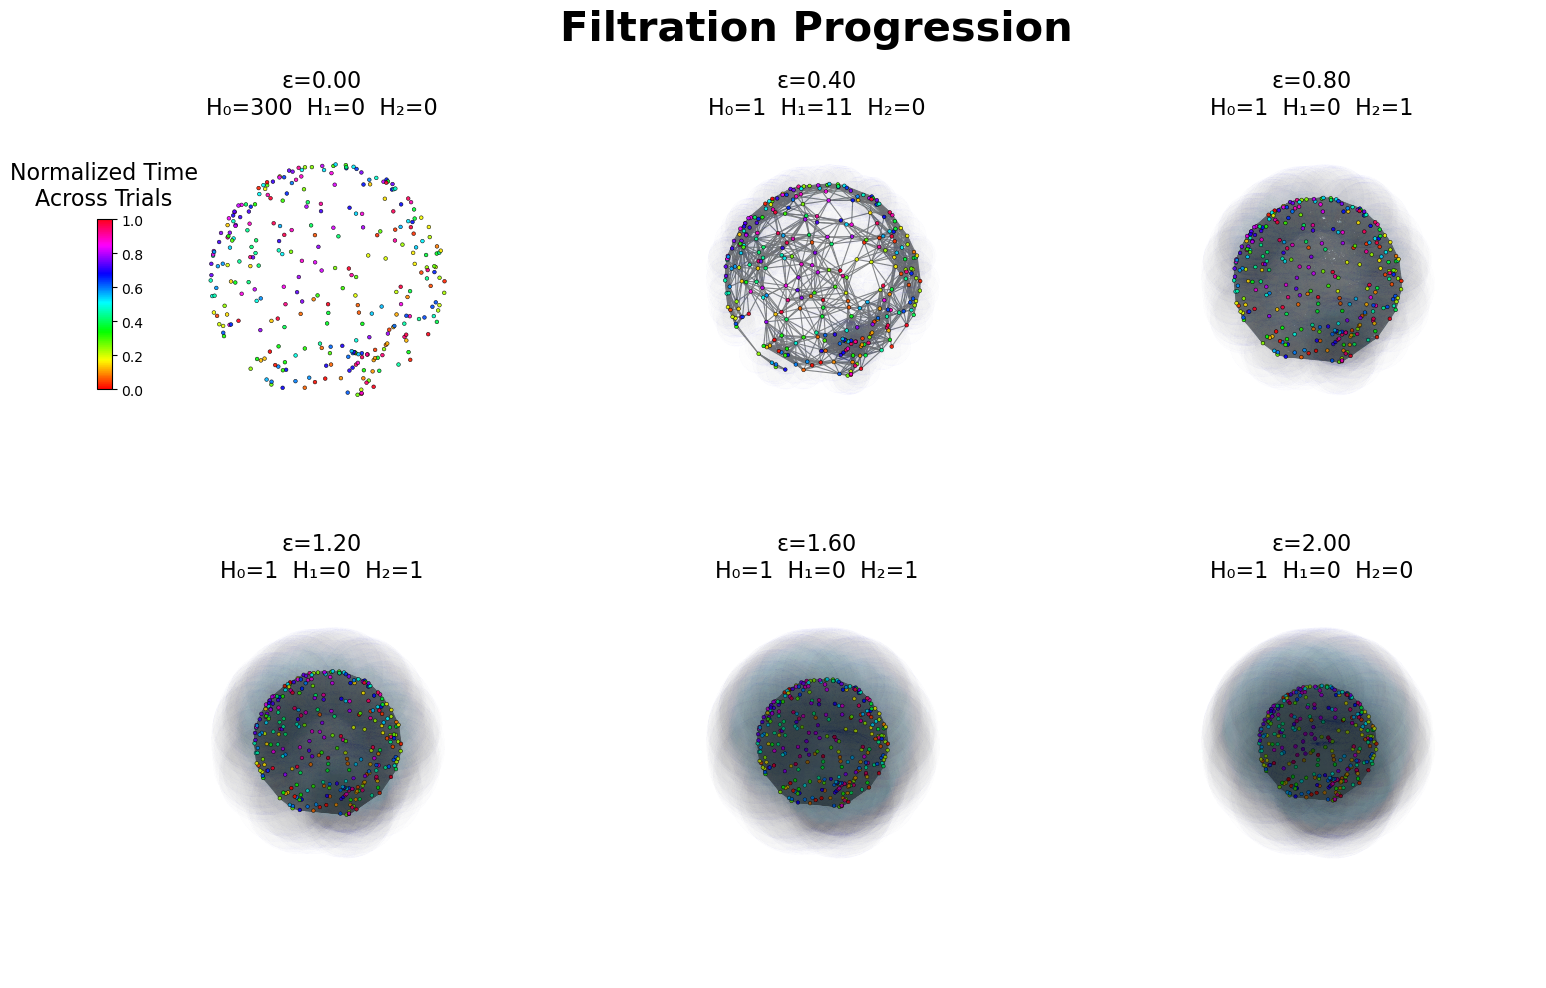

In [4]:

if __name__ == "__main__":
    pickle_directory_path = "C:\\Users\\denmanlab\\Desktop\\Emily_rotation\\CEBRA\\3d\\raw\\" # path to directory with embedding pickle files
    if pickle_directory_path and os.path.exists(pickle_directory_path):
        print(f"Loading embeddings from: {pickle_directory_path}")
        embedding_dict = load_embeddings_from_directory(pickle_directory_path)
        
        available_names = list(embedding_dict.keys())
        print(f"\nAvailable sessions: {available_names}")
        
        if len(available_names) == 0:
            # Okay so more chat file loading debugging
            import glob
            test_files = glob.glob(os.path.join(pickle_directory_path, "*.pkl"))
            if test_files:
                test_file = test_files[0]
                print(f"\nTesting with file: {os.path.basename(test_file)}")
                try:
                    # Try loading with standard pickle first
                    try:
                        with open(test_file, "rb") as f:
                            test_data = pickle.load(f)
                    except (RuntimeError, ValueError) as e:
                        if "CUDA" in str(e) or "torch" in str(e).lower():
                            try:
                                import torch
                                test_data = torch.load(test_file, map_location=torch.device('cpu'))
                                print(f"  Loaded with torch.load (CUDA->CPU)")
                            except Exception as e2:
                                print(f"  Error loading with torch.load: {e2}")
                                raise
                        else:
                            raise
                    
                    print(f"  Type: {type(test_data)}")
                    
                    # Handle tuple format
                    if isinstance(test_data, tuple) and len(test_data) >= 2:
                        print(f"  Tuple format detected (length: {len(test_data)})")
                        single_session_dict = test_data[0]
                        print(f"  First element type: {type(single_session_dict)}")
                        if isinstance(single_session_dict, dict):
                            print(f"  Session keys (mouse IDs): {list(single_session_dict.keys())[:10]}")
                            if len(single_session_dict) > 0:
                                first_key = list(single_session_dict.keys())[0]
                                first_session = single_session_dict[first_key]
                                print(f"  First session key: {first_key}")
                                if isinstance(first_session, dict):
                                    print(f"  First session keys: {list(first_session.keys())}")
                                    if 'embedding' in first_session:
                                        emb = first_session['embedding']
                                        # Handle PyTorch tensors
                                        if hasattr(emb, 'cpu'):
                                            emb = emb.cpu().numpy()
                                        elif hasattr(emb, 'numpy'):
                                            emb = emb.numpy()
                                        print(f"  Embedding shape: {np.array(emb).shape}")
                    elif isinstance(test_data, dict):
                        print(f"  Dictionary format detected")
                        print(f"  Session keys (mouse IDs): {list(test_data.keys())[:10]}")
                        if len(test_data) > 0:
                            first_key = list(test_data.keys())[0]
                            first_session = test_data[first_key]
                            print(f"  First session key: {first_key}")
                            print(f"  First session type: {type(first_session)}")
                            if isinstance(first_session, dict):
                                print(f"  First session keys: {list(first_session.keys())}")
                                if 'embedding' in first_session:
                                    emb = first_session['embedding']
                                    # Handle PyTorch tensors
                                    if hasattr(emb, 'cpu'):
                                        emb = emb.cpu().numpy()
                                    elif hasattr(emb, 'numpy'):
                                        emb = emb.numpy()
                                    print(f"  Embedding shape: {np.array(emb).shape}")
                    else:
                        print(f"  Unexpected type: {type(test_data)}")
                except Exception as e:
                    print(f"  Error loading test file: {e}")
                    import traceback
                    traceback.print_exc()
            else:
                print(f"  No .pkl files found in directory!")
            
            raise ValueError("No embeddings loaded. Please check the file structure and loading function.")
        
        mouse_name = "LGN_3d_CEBRA_unsup_time_color_exchange_d4"  # can also use to specify file/session
        
        print(f"\nUsing session: {mouse_name}\n")

    
    embedding_filtration_workflow(embedding_dict, mouse_name, n_samples=300,diameter_range=(0, 2), n_filtration_steps=6)
